# Import libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# Read the dataset

In [3]:
fpt_dataset = pd.read_csv('FPT.csv')
msn_dataset = pd.read_csv('MSN.csv')
pnj_dataset = pd.read_csv('PNJ.csv')
vic_dataset = pd.read_csv('VIC.csv')

In [4]:
fpt_dataset.isnull().sum()

Ticker           0
Date/Time        0
Open             0
High             0
Low              0
Close            0
Volume           0
Open Interest    0
dtype: int64

In [5]:
msn_dataset.isnull().sum()

Ticker           0
Date/Time        0
Open             0
High             0
Low              0
Close            0
Volume           0
Open Interest    0
dtype: int64

In [6]:
pnj_dataset.isnull().sum()

Ticker           0
Date/Time        0
Open             0
High             0
Low              0
Close            0
Volume           0
Open Interest    0
dtype: int64

In [7]:
vic_dataset.isnull().sum()

Ticker           0
Date/Time        0
Open             0
High             0
Low              0
Close            0
Volume           0
Open Interest    0
dtype: int64

As we can see, there's no missing data in each dataset.

# Exploring the data

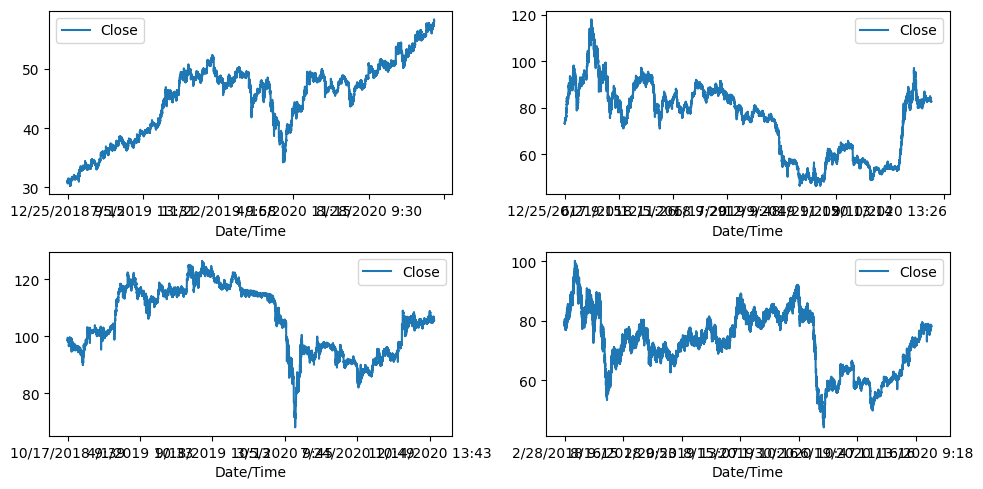

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

fpt_dataset.plot.line(x="Date/Time", y="Close", ax=ax[0, 0])
msn_dataset.plot.line(x="Date/Time", y="Close", ax=ax[0, 1])
vic_dataset.plot.line(x="Date/Time", y="Close", ax=ax[1, 0])
pnj_dataset.plot.line(x="Date/Time", y="Close", ax=ax[1, 1])
plt.tight_layout()
plt.show()

As can be seen, the price of the stock fluctated.

# Generate the target

The target is not "does the price go up or go down", but "how much the price change". Also, we will have to use the data of the previous day to predict the price of the next day.

The following code generate the target column, which is "change" column.

In [9]:
def generate_target(dataset: pd.DataFrame):
    dataset.insert(len(dataset.columns), 'NextClose', dataset['Close'].shift(-1))
    dataset.insert(len(dataset.columns), 'Change', dataset['NextClose'] - dataset['Close'])

In [10]:
generate_target(fpt_dataset)
generate_target(msn_dataset)
generate_target(pnj_dataset)
generate_target(vic_dataset)

In [11]:
fpt_dataset.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest,NextClose,Change
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0,30.81,-0.08
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0,30.74,-0.07
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0,30.74,0.00
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0,30.74,0.00
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0,30.74,0.00


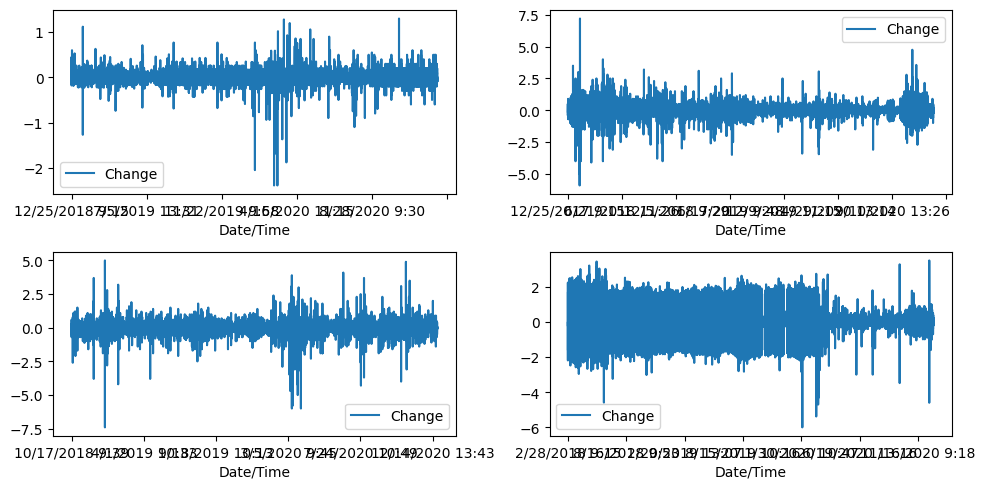

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(10, 5))

fpt_dataset.plot.line(x="Date/Time", y="Change", ax=ax[0, 0])
msn_dataset.plot.line(x="Date/Time", y="Change", ax=ax[0, 1])
vic_dataset.plot.line(x="Date/Time", y="Change", ax=ax[1, 0])
pnj_dataset.plot.line(x="Date/Time", y="Change", ax=ax[1, 1])
plt.tight_layout()
plt.show()

We will not use the most recent line of the dataset (the last line) - it is not associated with any future data.

In [13]:
fpt_dataset = fpt_dataset.iloc[:-1]
msn_dataset = msn_dataset.iloc[:-1]
pnj_dataset = pnj_dataset.iloc[:-1]
vic_dataset = vic_dataset.iloc[:-1]

# Set up the metrics

Generally, the prediction of stock aims for best profit for the stock trader. So, a false positive (predict the price to increase while it actually decreases) is more harmful than a false negative (predict the price to decrease while it actually increases).

Therefore, there are two metrics to evaluate a model.

- Precision: $Precision = \dfrac{TP}{TP+FP}$.

The change determines the 'label' of the prediction: positive (increase) or negative (decrease). "No change" in the target is counted as positive, and "no change" in the prediction is counted as negative.

In [14]:
from sklearn.metrics import precision_score

def calculate_precision(y_true: pd.Series, y_pred: pd.Series):
    """
    Calculate the precision score, when both y_true and y_pred are
    regression values.

    Parameters
    ----------
    y_true : pd.Series
        The true values.
    y_pred : pd.Series
        The predicted values.

    Returns
    -------
    float
        The precision score.
    """
    y_true_label = np.select([y_true > 0, y_true < 0], [1, -1], default=1)
    y_pred_label = np.select([y_pred > 0, y_pred < 0], [1, -1], default=-1)
    return precision_score(y_true_label, y_pred_label)

- Weighted Mean Squared Error: $WMSE=\dfrac{1}{n}∑_{i=1}^{n}w_{i}(y_i-\hat{y_i})^{2}$.

Retain full penalty for false positive, and apply lesser penalty for false negative (0.8). If true postive or true negative, the weight is much lesser (0.5).

In [15]:
from sklearn.metrics import mean_squared_error

def calculate_weighted_mse(y_true: pd.Series, y_pred: pd.Series):
    """
    Calculate the weighted mean squared error, when both y_true and y_pred are
    regression values.

    Parameters
    ----------
    y_true : pd.Series
        The true values.
    y_pred : pd.Series
        The predicted values.

    Returns
    -------
    float
        The precision score.
    """
    y_true_label = np.select([y_true > 0, y_true < 0], [1, -1], default=1)
    y_pred_label = np.select([y_pred > 0, y_pred < 0], [1, -1], default=-1)
    weights = np.select([y_true_label == y_pred_label,
                         y_true_label == -1,
                         y_true_label == 1], [0.5, 0.8, 1.0], default=1.0)
    return mean_squared_error(y_true, y_pred, sample_weight=weights)

# Test machine learning models

Because the dataset is time-series, we cannot use cross-validation for the entire dataset. This will cause feature leakage where the data of the future is used to predict past price change.

In this section we use only the FPT dataset for experimenting purpose in training.

In [16]:
from sklearn.preprocessing import MinMaxScaler

fpt_scaler = MinMaxScaler((-1, 1))
fpt_scaler_target = MinMaxScaler((-1, 1))

training_dataset = fpt_dataset.drop(columns=['Ticker', 'Date/Time', 'NextClose'])
training_dataset = pd.DataFrame(fpt_scaler.fit_transform(training_dataset), columns=training_dataset.columns)
X = training_dataset.drop(columns=['Change'])
y = fpt_scaler_target.fit_transform(fpt_dataset[['Change']]).reshape(-1)

Train a few machine learning regression models.

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    SVR()
]

num_train_samples = math.ceil(len(X) * 0.8)

X_train = X[:num_train_samples]
y_train = y[:num_train_samples]
X_test = X[num_train_samples:]
y_test = y[num_train_samples:]
unscaled_true = fpt_dataset['Change'][num_train_samples:].to_numpy().reshape(-1, 1)

model_results = []

for model in tqdm(models):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    unscaled_pred = fpt_scaler_target.inverse_transform(y_pred.reshape(-1, 1))

    model_results.append({
        'model': model.__class__.__name__,
        'prediction': unscaled_pred.reshape(-1),
        'precision': calculate_precision(unscaled_pred, unscaled_true),
        'weighted_mse': calculate_weighted_mse(unscaled_pred, unscaled_true)
    })

100%|██████████| 4/4 [01:05<00:00, 16.39s/it]


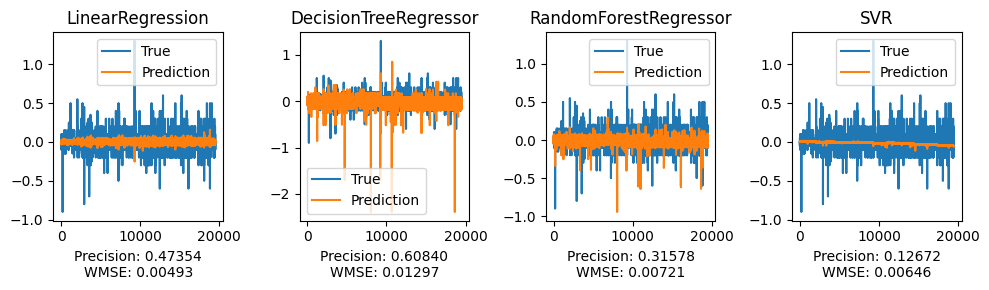

In [18]:
fig, ax = plt.subplots(1, 4, figsize=(10, 3))

for i, model_result in enumerate(model_results):
    ax[i].plot(fpt_dataset['Change'][num_train_samples:].to_list(), label='True')
    ax[i].plot(model_result['prediction'], label='Prediction')
    ax[i].set_title(model_result['model'])
    ax[i].legend()
    ax[i].set_xlabel(f'Precision: {model_result["precision"]:.5f}\n' +
                     f'WMSE: {model_result["weighted_mse"]:.5f}')

plt.tight_layout()
plt.show()

Testing on MSN dataset.

In [19]:
msn_scaler = MinMaxScaler((-1, 1))
msn_scaler_target = MinMaxScaler((-1, 1))

test_dataset = msn_dataset.drop(columns=['Ticker', 'Date/Time', 'NextClose', 'Change'])
test_dataset = pd.DataFrame(msn_scaler.fit_transform(test_dataset), columns=test_dataset.columns)
X_test = test_dataset
y_test = msn_scaler_target.fit_transform(msn_dataset[['Change']]).reshape(-1)
unscaled_test = msn_dataset[['Change']]

new_model_results = []

for model in tqdm(models):
    y_pred = model.predict(X_test)
    
    unscaled_pred = msn_scaler_target.inverse_transform(y_pred.reshape(-1, 1))

    new_model_results.append({
        'model': model.__class__.__name__,
        'prediction': unscaled_pred.reshape(-1),
        'precision': calculate_precision(unscaled_pred, unscaled_test),
        'weighted_mse': calculate_weighted_mse(unscaled_pred, unscaled_test)
    })

100%|██████████| 4/4 [00:06<00:00,  1.59s/it]


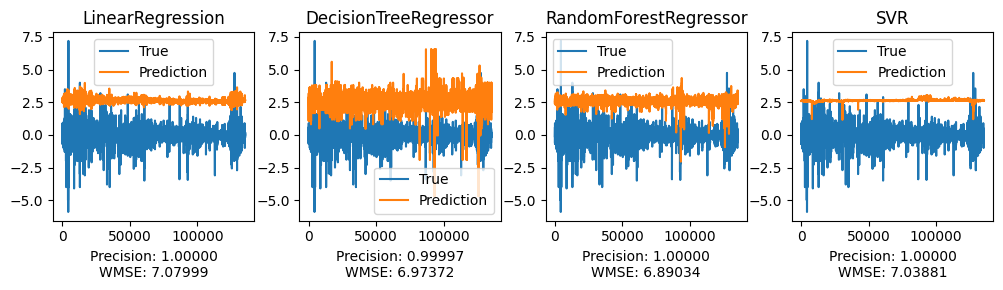

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(10, 3))

for i, new_model_result in enumerate(new_model_results):
    ax[i].plot(msn_dataset['Change'].to_list(), label='True')
    ax[i].plot(new_model_result['prediction'], label='Prediction')
    ax[i].set_title(new_model_result['model'])
    ax[i].legend()
    ax[i].set_xlabel(f'Precision: {new_model_result["precision"]:.5f}\n' +
                    f'WMSE: {new_model_result["weighted_mse"]:.5f}')

plt.tight_layout()
plt.show()

From this result, it can be concluded that the model does not perform well in test data.

# LSTM models

LSTM (Long-Short Term Memory) is a Recurrent Neural Network where each output becomes the input of the next output. Therefore, this model is suitable for time-series tasks such as predicting the stock change.

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout

In [22]:
lstm_model = Sequential()
lstm_model.add(InputLayer(shape=(100,6)))
lstm_model.add(LSTM(units=50, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=60, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=80, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=120))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(units=1))

lstm_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In this section we use only the FPT dataset for experimenting purpose in training, using scaled data.

In [23]:
fpt_scaler = MinMaxScaler((-1, 1))
fpt_scaler_target = MinMaxScaler((-1, 1))

training_dataset_lstm = fpt_dataset.drop(columns=['Ticker', 'Date/Time', 'NextClose'])
training_dataset_lstm = pd.DataFrame(fpt_scaler.fit_transform(training_dataset_lstm), columns=training_dataset_lstm.columns)
X_train_lstm = training_dataset_lstm.drop(columns=['Change'])
y_train_lstm = fpt_scaler_target.fit_transform(fpt_dataset[['Change']]).reshape(-1)

X_train_lstm_batch = []
y_train_lstm_batch = []

BATCH_TIMESTEPS = 1000

for i in tqdm(range(BATCH_TIMESTEPS, len(X_train_lstm))):
    X_train_lstm_batch.append(X_train_lstm.iloc[i-BATCH_TIMESTEPS:i].to_numpy())
    y_train_lstm_batch.append(y_train_lstm[i])

100%|██████████| 96405/96405 [00:02<00:00, 35287.95it/s]


In [24]:
num_train_samples = math.ceil(len(X_train_lstm_batch) * 0.8)

lstm_model.fit(np.array(X_train_lstm_batch[:num_train_samples]),
               np.array(y_train_lstm_batch[:num_train_samples]), epochs=10)

Epoch 1/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 275s 112ms/step - loss: 0.0022 - mean_absolute_error: 0.0296
Epoch 2/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 270s 112ms/step - loss: 0.0012 - mean_absolute_error: 0.0215
Epoch 3/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 269s 112ms/step - loss: 0.0011 - mean_absolute_error: 0.0198
Epoch 4/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 270s 112ms/step - loss: 0.0011 - mean_absolute_error: 0.0189
Epoch 5/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 269s 112ms/step - loss: 0.0011 - mean_absolute_error: 0.0182
Epoch 6/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 269s 112ms/step - loss: 0.0010 - mean_absolute_error: 0.0179
Epoch 7/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 270s 112ms/step - loss: 0.0012 - mean_absolute_error: 0.0182
Epoch 8/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 269s 111ms/step - loss: 0.0010 - mean_absolute_error: 0.0179
Epoch 9/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 269s 111ms/step - loss: 0.0011 - mean_absolute_error: 0.0180
Epoch 10/10
2411/2411 ━━━━━━━━━━━━━━━━━━━━ 269s 111ms/step - loss: 0.0012

In [25]:
y_pred = lstm_model.predict(np.array(X_train_lstm_batch[num_train_samples:]))
unscaled_pred = fpt_scaler_target.inverse_transform(y_pred.reshape(-1, 1))
unscaled_true = fpt_dataset['Change'][num_train_samples+BATCH_TIMESTEPS:].to_numpy().reshape(-1, 1)

603/603 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step


In [26]:
calculate_precision(unscaled_true, unscaled_pred)

0.8000103729059697

In [27]:
calculate_weighted_mse(unscaled_true, unscaled_pred)

0.0057408851381093

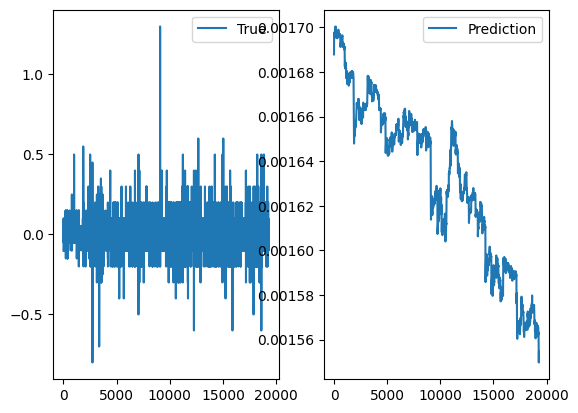

In [28]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(unscaled_true, label='True')
ax[0].legend()
ax[1].plot(unscaled_pred, label='Prediction')
ax[1].legend()
plt.show()

The LSTM model with unscaled can predict how much the stock price change, but only the direction. Also, it doesn't work well in unseen data. Test with trained data to make sure the model works correctly.

In [29]:
y_train_pred = lstm_model.predict(np.array(X_train_lstm_batch[:num_train_samples]))
unscaled_pred = fpt_scaler_target.inverse_transform(y_train_pred.reshape(-1, 1))
unscaled_true = fpt_dataset['Change'][BATCH_TIMESTEPS:num_train_samples+BATCH_TIMESTEPS].to_numpy().reshape(-1, 1)

2411/2411 ━━━━━━━━━━━━━━━━━━━━ 109s 45ms/step


In [ ]:
fig, ax = plt.subplots(1, 2)

ax[0].plot(unscaled_true, label='True')
ax[0].legend()
ax[1].plot(unscaled_pred, label='Prediction')
ax[1].legend()
plt.show()

# Full dataset

Now we will use LSTM to train all datas.

In [31]:
lstm_final_model = Sequential()
lstm_final_model.add(InputLayer(shape=(100,6)))
lstm_final_model.add(LSTM(units=50, return_sequences=True))
lstm_final_model.add(Dropout(0.2))
lstm_final_model.add(LSTM(units=60, return_sequences=True))
lstm_final_model.add(Dropout(0.2))
lstm_final_model.add(LSTM(units=80, return_sequences=True))
lstm_final_model.add(Dropout(0.2))
lstm_final_model.add(LSTM(units=120))
lstm_final_model.add(Dropout(0.2))
lstm_final_model.add(Dense(units=1))

lstm_final_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

In [32]:
def data_preprocessing(dataset):
    scaler_X = MinMaxScaler((-1, 1))
    scaler_target = MinMaxScaler((-1, 1))
    X = dataset.drop(columns=['Ticker', 'Date/Time', 'NextClose', 'Change'])
    y = dataset[['Change']]
    
    X = pd.DataFrame(scaler_X.fit_transform(X), columns=X.columns)
    y = scaler_target.fit_transform(y)
    
    X_batch = []
    y_batch = []
    
    BATCH_TIMESTEPS = 100

    for i in tqdm(range(BATCH_TIMESTEPS, len(X))):
        X_batch.append(X.iloc[i-BATCH_TIMESTEPS:i].to_numpy())
        y_batch.append(y[i])
    
    return scaler_X, scaler_target, X_batch, y_batch

In [33]:
fpt_training_metadata = data_preprocessing(fpt_dataset)
msn_training_metadata = data_preprocessing(msn_dataset)
pnj_training_metadata = data_preprocessing(pnj_dataset)
vic_training_metadata = data_preprocessing(vic_dataset)

100%|██████████| 101165/101165 [00:02<00:00, 35801.05it/s]


In [34]:
X_train_batch = []
y_train_batch = []
X_test_batch = []
y_test_batch = []
metadatas = [fpt_training_metadata, msn_training_metadata,
            pnj_training_metadata, vic_training_metadata]

for metadata in metadatas:
    num_train_samples = math.ceil(len(metadata[2]) * 0.8)
    X_train_batch.extend(metadata[2][:num_train_samples])
    y_train_batch.extend(metadata[3][:num_train_samples])
    
    X_test_batch.extend(metadata[2][num_train_samples:])
    y_test_batch.extend(metadata[3][num_train_samples:])

In [35]:
lstm_final_model.fit(np.array(X_train_batch),
                     np.array(y_train_batch), epochs=5)

Epoch 1/5
11474/11474 ━━━━━━━━━━━━━━━━━━━━ 202s 17ms/step - loss: 0.0331 - mean_absolute_error: 0.1517
Epoch 2/5
11474/11474 ━━━━━━━━━━━━━━━━━━━━ 199s 17ms/step - loss: 0.0321 - mean_absolute_error: 0.1475
Epoch 3/5
11474/11474 ━━━━━━━━━━━━━━━━━━━━ 200s 17ms/step - loss: 0.0317 - mean_absolute_error: 0.1463
Epoch 4/5
11474/11474 ━━━━━━━━━━━━━━━━━━━━ 199s 17ms/step - loss: 0.0322 - mean_absolute_error: 0.1480
Epoch 5/5
11474/11474 ━━━━━━━━━━━━━━━━━━━━ 200s 17ms/step - loss: 0.0311 - mean_absolute_error: 0.1431


0it [00:00, ?it/s]

609/609 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
1it [00:04,  4.73s/it]

846/846 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


2it [00:10,  5.55s/it]

783/783 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


3it [00:16,  5.69s/it]

633/633 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step


4it [00:21,  5.32s/it]


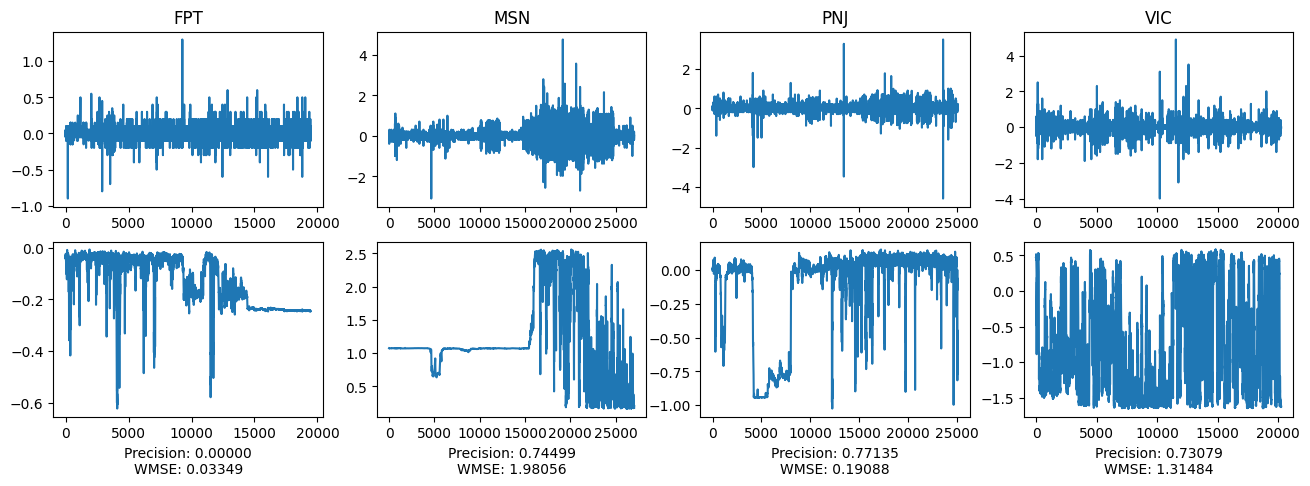

In [49]:
fig, ax = plt.subplots(2,4,figsize=(16,5))
datasets = [fpt_dataset, msn_dataset, pnj_dataset, vic_dataset]
datasets_name = ['FPT', 'MSN', 'PNJ', 'VIC']

for index, metadata in tqdm(enumerate(metadatas)):
    num_train_samples = math.ceil(len(metadata[2]) * 0.8)
    y_pred = lstm_final_model.predict(np.array(metadata[2][num_train_samples:]))
    unscaled_pred = metadata[1].inverse_transform(y_pred.reshape(-1, 1))
    unscaled_true = datasets[index]['Change'][num_train_samples+100:].to_numpy().reshape(-1, 1)
    
    precision = calculate_precision(unscaled_true, unscaled_pred)
    wmse = calculate_weighted_mse(unscaled_true, unscaled_pred)
    
    ax[0, index].set_title(datasets_name[index])
    ax[0, index].plot(unscaled_true.reshape(-1))
    ax[1, index].plot(unscaled_pred)
    ax[1, index].set_xlabel(f'Precision: {precision:.5f}\n' +
                    f'WMSE: {wmse:.5f}')
    
plt.show()

# Conclusion

In conclusion, LSTM model is a good model to predict the movement of the stock price in exact amount. However, due to limited resource, we cannot train it good enough to predict it, especially FPT stock. Therefore, there is fields that need researching to achieve better result.